<a href="https://colab.research.google.com/github/redman157/HocML/blob/master/colaborative-filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pson2809","key":"f045f4a4adb9707f5c86d18bc28608b2"}'}

In [2]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

-rw-r--r-- 1 root root 64 Mar  6 22:44 kaggle.json


In [0]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# List available datasets.
!kaggle datasets list

ref                                                          title                                                size  lastUpdated          downloadCount  
-----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
ronitf/heart-disease-uci                                     Heart Disease UCI                                     3KB  2018-06-25 11:33:56          13076  
russellyates88/suicide-rates-overview-1985-to-2016           Suicide Rates Overview 1985 to 2016                 396KB  2018-12-01 19:18:25           9280  
mohansacharya/graduate-admissions                            Graduate Admissions                                   9KB  2018-12-28 10:07:14          12016  
bigquery/crypto-ethereum-classic                             Ethereum Classic Blockchain                          69GB  2019-03-04 14:57:33              0  
iarunava/cell-images-for-detecting-malaria                

In [6]:
!kaggle datasets download -d rounakbanik/the-movies-dataset
!kaggle datasets download -d tmdb/tmdb-movie-metadata

100% 227M/228M [00:01<00:00, 100MB/s] 
100% 228M/228M [00:01<00:00, 124MB/s]
  0% 0.00/9.30M [00:00<?, ?B/s]
100% 9.30M/9.30M [00:00<00:00, 82.4MB/s]


In [7]:
!unzip the-movies-dataset.zip

Archive:  the-movies-dataset.zip
  inflating: ratings.csv             
  inflating: ratings_small.csv       
  inflating: links.csv               
  inflating: links_small.csv         
  inflating: keywords.csv            
  inflating: movies_metadata.csv     
  inflating: credits.csv             


In [8]:
!unzip tmdb-movie-metadata.zip

Archive:  tmdb-movie-metadata.zip
  inflating: tmdb_5000_credits.csv   
  inflating: tmdb_5000_movies.csv    


In [0]:
import seaborn as sns
import pandas as pd
import numpy as np
import json
from sklearn.preprocessing import StandardScaler

df1 = pd.read_csv('tmdb_5000_credits.csv')
df2 = pd.read_csv('tmdb_5000_movies.csv')

In [16]:
!sudo pip install scikit-surprise

In [0]:
def load_tmdb_movies(path):
  df = pd.read_csv(path)
  df['release_date'] = pd.to_datetime(df['release_date'])
  json_columns = ['genres', 'keywords', 'production_countries',
                    'production_companies', 'spoken_languages']
  for column in json_columns:
    df[column] = df[column].apply(json.loads)
  return df
def load_tmdb_credits(path):
    df = pd.read_csv(path)
    json_columns = ['cast', 'crew']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df
def safe_access(container, index_values):
  result  = container
  try:
    for idx in index_values:
      result = result[idx]
    return result
  except IndexError or KeyError:
    return pd.np.nan
def get_director(crew_data):
    directors = [x['name'] for x in crew_data if x['job'] == 'Director']
    return safe_access(directors, [0])


In [22]:
load_tmdb_movies('tmdb_5000_movies.csv')

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.avatarmovie.com/,19995,"[{'id': 1463, 'name': 'culture clash'}, {'id':...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{'name': 'Ingenious Film Partners', 'id': 289...","[{'iso_3166_1': 'US', 'name': 'United States o...",2009-12-10,2787965087,162.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",http://disney.go.com/disneypictures/pirates/,285,"[{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2007-05-19,961000000,169.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{'id': 470, 'name': 'spy'}, {'id': 818, 'name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2015-10-26,880674609,148.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",http://www.thedarkknightrises.com/,49026,"[{'id': 849, 'name': 'dc comics'}, {'id': 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{'name': 'Legendary Pictures', 'id': 923}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-07-16,1084939099,165.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://movies.disney.com/john-carter,49529,"[{'id': 818, 'name': 'based on novel'}, {'id':...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-03-07,284139100,132.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124
5,258000000,"[{'id': 14, 'name': 'Fantasy'}, {'id': 28, 'na...",http://www.sonypictures.com/movies/spider-man3/,559,"[{'id': 851, 'name': 'dual identity'}, {'id': ...",en,Spider-Man 3,The seemingly invincible Spider-Man goes up ag...,115.699814,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...","[{'iso_3166_1': 'US', 'name': 'United States o...",2007-05-01,890871626,139.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,The battle within.,Spider-Man 3,5.9,3576
6,260000000,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",http://disney.go.com/disneypictures/tangled/,38757,"[{'id': 1562, 'name': 'hostage'}, {'id': 2343,...",en,Tangled,When the kingdom's most wanted-and most charmi...,48.681969,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-11-24,591794936,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,They're taking adventure to new lengths.,Tangled,7.4,3330
7,280000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://marvel.com/movies/movie/193/avengers_ag...,99861,"[{'id': 8828, 'name': 'marvel comic'}, {'id': ...",en,Avengers: Age of Ultron,When Tony Stark tries to jumpstart a dormant p...,134.279229,"[{'name': 'Marvel Studios', 'id': 420}, {'name...","[{'iso_3166_1': 'US', 'name': 'United States o...",2015-04-22,1405403694,141

In [24]:
df2.head(5)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [0]:
ratings['number_of_ratings'] = df.groupby('title')['rating'].count()
ratings.number_of_ratings.unique()

array([ 1,  2,  4,  3,  7,  6,  9,  5,  8, 11])

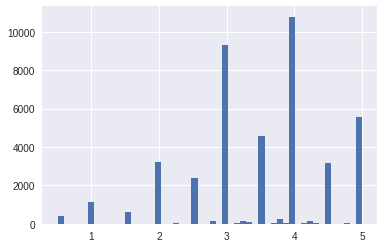

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
ratings['rating'].hist(bins=50)


In [0]:
df.head(5)

,id,title,userId,movieId,rating,timestamp
0,862,Toy Story,1,110,1.0,1425941529
1,8844,Jumanji,1,147,4.5,1425942435
2,15602,Grumpier Old Men,1,858,5.0,1425941523
3,31357,Waiting to Exhale,1,1221,5.0,1425941546
4,11862,Father of the Bride Part II,1,1246,5.0,1425941556


In [0]:
movie_matrix = df.pivot_table(index='userId', columns='title', values='rating')
movie_matrix.head()


title,!Women Art Revolution,#1 Cheerleader Camp,#Horror,#chicagoGirl,"$1,000 on the Black","$100,000 for Ringo",$5 a Day,$50K and a Call Girl: A Love Story,$9.99,$ellebrity,...,Путь к себе,Семь кабинок,Совершенно серьезно,Убить дракона,Юленька,هیچ کجا هیچ کس,‘Rameau’s Nephew’ by Diderot (Thanx to Dennis Young) by Wilma Schoen,’Round Midnight,…And the Fifth Horseman Is Fear,ファンタスティポ
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
ratings.sort_values('number_of_ratings', ascending=False).head(10)

,rating,number_of_ratings
title,,
Cinderella,4.136364,11
Alice in Wonderland,2.722222,9
Hamlet,3.500000,9
Les Misérables,2.937500,8
Beauty and the Beast,3.875000,8
The Three Musketeers,3.285714,7
Treasure Island,3.357143,7
Blackout,3.285714,7
A Christmas Carol,3.642857,7
